In [665]:
from collections import Counter

from scipy.stats import chi2_contingency
import scipy.linalg as la
import scipy.stats

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize

np.set_printoptions(linewidth=np.inf)

Uvažujte model hromadné obsluhy 
M
∣
G
∣
∞


 - Požadavky přichází podle Poissonova procesu s intenzitou λ=10s−1

 - Doba obsluhy jednoho požadavku (v sekundách) má rozdělení S∼Ga(4,2), tj. Gamma s parametry a=4, p=2.

 - Časy mezi příchody a časy obsluhy jsou nezávislé.

 - Systém má (teoreticky) nekonečně paralelních obslužných míst (každý příchozí je rovnou obsluhován).

Označme  Nt počet zákazníků v systému v čase. Předpokládejme, že na začátku je systém prázdný, tj. N0 = 0.

## Úloha 1
Simulujte jednu trajektorii {Nt(ω)∣t∈(0,10 s)} Průběh trajektorie graficky znázorněte.

In [751]:
def simulate(T, G):
    N = [0]
    active = []
    
    for index_t, time in enumerate(T):
        N.append(N[-1] + 1)
        active.append(index_t)
        
        for index_g, gamma in enumerate(G):
            if index_g <= index_t:
                if (T[index_g] + gamma <= time) and (index_g in active):
                    N[-1] -= 1
                    active.remove(index_g)
            else:
                break
        
    return N

In [774]:
lambd = 10
t_max = 10

p, a = 2, 4

# Pocet udalosti vygenerovany z Poissonovho rozdelenia s intenzitou lambda * tmax
n = np.random.poisson(lambd * t_max)

# Casy prichodu - vygenerujeme n uniformnych velicin od nuly po tmax, casy zoradime, pridame pociatocny cas 0, kedy je v systeme 0 poziadaviek
U = np.random.uniform(low=0, high=t_max, size=n)
G = np.random.gamma(p, 1/a, size=n)

T = sorted(list(U))

N = simulate(T, G)

if (T[-1] != n):
    T.append(10)
    N.append(N[-1])
    
T.insert(0, 0)

print(len(N))
print(N[:10])

107
[0, 1, 2, 3, 4, 5, 5, 4, 5, 6]


In [775]:
print(len(T))
print(T[:10])

107
[0, 0.22961973574785466, 0.319038183058451, 0.5003454779336214, 0.5431214494863945, 0.5666962446766166, 0.6762472115483853, 0.8519808614898172, 0.8581292988390032, 0.8975396559571458]


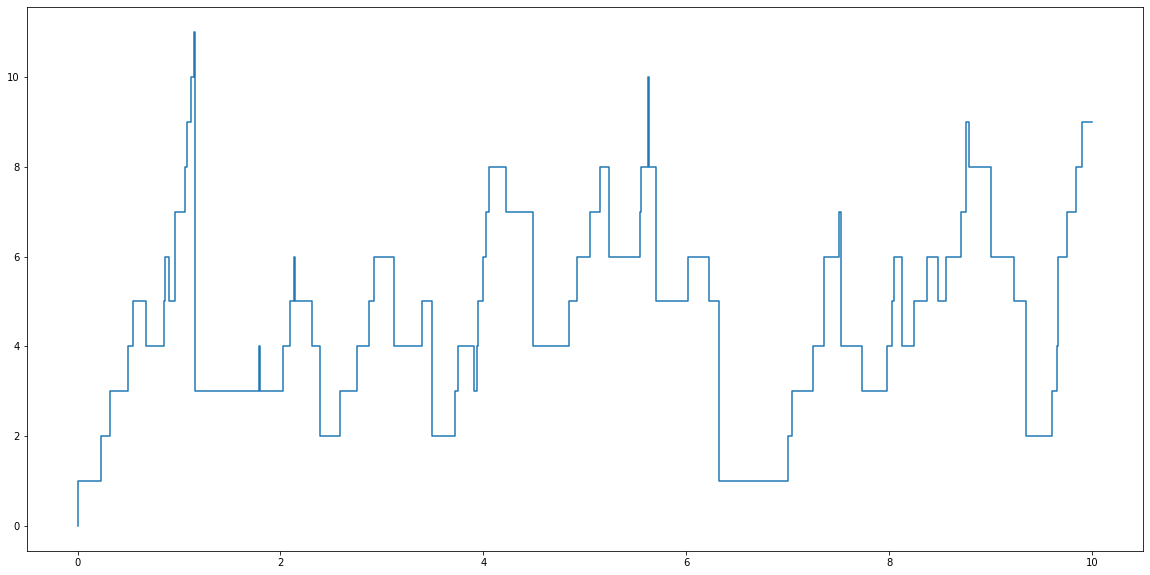

In [776]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

plt.step(T, N)

## Úloha 2
Simulujte n=500 nezávislých trajektorií pro t∈(0,100). Na základě těchto simulací odhadněte rozdělení náhodné veličiny 
N100.

In [753]:
lambd = 10
t_max = 100

p, a = 2, 4

obs = {}

for i in range(0, 500):
    # Pocet udalosti vygenerovany z Poissonovho rozdelenia s intenzitou lambda * tmax
    n = np.random.poisson(lambd * t_max)

    # Times of arrival - vygenerujeme n uniformnych velicin od nuly po tmax, casy zoradime, pridame pociatocny cas 0
    # Kedy je v systeme 0 poziadaviek
    U = np.random.uniform(low=0, high=t_max, size=n)
    G = np.random.gamma(p, 1/a, size=n)

    T = sorted(list(U))

    N = simulate(T, G)

    if N[-1] not in obs:
        obs[N[-1]] = 1
    else:
        obs[N[-1]] += 1
        
print(obs)

{5: 69, 6: 87, 4: 67, 8: 53, 7: 68, 9: 42, 10: 25, 3: 48, 11: 14, 2: 18, 12: 3, 14: 1, 1: 3, 13: 2}


In [754]:
obs[0] = 0
obs = dict(sorted(obs.items()))
print(obs)

{0: 0, 1: 3, 2: 18, 3: 48, 4: 67, 5: 69, 6: 87, 7: 68, 8: 53, 9: 42, 10: 25, 11: 14, 12: 3, 13: 2, 14: 1}


In [755]:
dist = {key: val / 500 for key, val in obs.items()}
dist = dict(sorted(dist.items()))
print(dist)

{0: 0.0, 1: 0.006, 2: 0.036, 3: 0.096, 4: 0.134, 5: 0.138, 6: 0.174, 7: 0.136, 8: 0.106, 9: 0.084, 10: 0.05, 11: 0.028, 12: 0.006, 13: 0.004, 14: 0.002}


In [756]:
# Make sure the probabilities sum up to one
sum(dist.values(), 0.0)

1.0

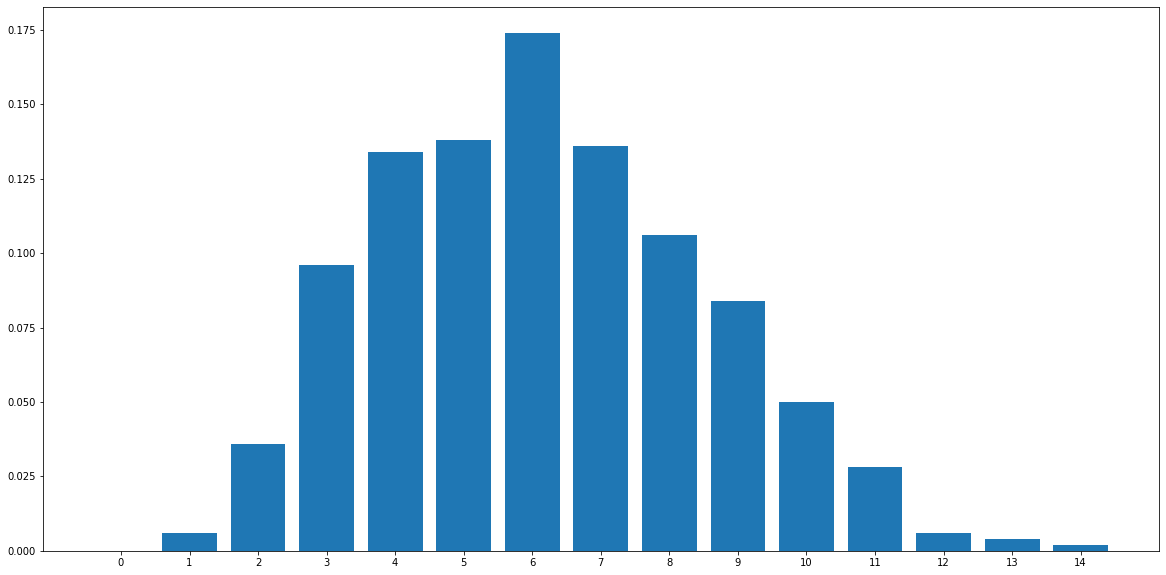

In [757]:
plt.figure(figsize=(20,10))
plt.bar(dist.keys(), dist.values())
plt.xticks(range(0, max(dist.keys()) + 1))
plt.show()

## Úloha 3
Diskutujte, jaké je limitní rozdělení tohoto systému pro t→+∞. Pomocí vhodného testu otestujte na hladině významnosti 5 %, zda výsledky simulace N100 odpovídají tomuto rozdělení.

In [758]:
# Function to create a new dictionary, keys to be merged specified in argument
def mergeColumns(dictionary, new_key, to_merge):
    dictionary_merged = dictionary.copy()
    
    merged = 0
    for key in to_merge:
        merged += dictionary_merged.get(key)
        dictionary_merged.pop(key)

    dictionary_merged.update({new_key:merged})

    return dictionary_merged

In [759]:
mu = scipy.stats.gamma.mean(p, loc=0, scale=1/a)
mu

0.5

In [765]:
poisson = {}
for i in range(0, max(dist.keys())):
    poisson[i] = scipy.stats.poisson.pmf(i, lambd * mu)
    
poisson[max(dist.keys())] = 1 - sum(poisson.values())

poisson = dict(sorted(poisson.items()))

In [766]:
poisson.update((key, round(value * 500)) for key, value in poisson.items())

In [767]:
to_merge = []

for key, value in obs.items():
    if value < 5:
        to_merge.append(key)
        
for key, value in poisson.items():        
    if value < 5 and key not in to_merge:
        to_merge.append(key)       

to_merge

[0, 1, 12, 13, 14, 11]

In [768]:
exp_merged = mergeColumns(poisson, 'merged', to_merge)
print(exp_merged)

{2: 42, 3: 70, 4: 88, 5: 88, 6: 73, 7: 52, 8: 33, 9: 18, 10: 9, 'merged': 27}


In [769]:
exp_merged_list = list(exp_merged.values())
exp_merged_list

[42, 70, 88, 88, 73, 52, 33, 18, 9, 27]

In [770]:
obs_merged = mergeColumns(obs, 'merged', to_merge)
print(obs_merged)

{2: 18, 3: 48, 4: 67, 5: 69, 6: 87, 7: 68, 8: 53, 9: 42, 10: 25, 'merged': 23}


In [771]:
obs_merged_list = list(obs_merged.values())
obs_merged_list

[18, 48, 67, 69, 87, 68, 53, 42, 25, 23]

In [777]:
scipy.stats.chisquare(f_obs=obs_merged_list, f_exp=exp_merged_list)

Power_divergenceResult(statistic=110.50846538038319, pvalue=1.1585142271554297e-19)

In [778]:
dof = len(obs_merged_list) - 1
dof

9